In [2]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd
from time import sleep
from sklearn.model_selection import train_test_split
plt.rcParams['axes.grid'] = True

In [3]:
# load data
data_dir = '../kaggle/all'
x_global_train = np.load(os.path.join(data_dir, 'train.npz'))['x']
y_global_train = np.load(os.path.join(data_dir, 'train.npz'))['y']
x_global_test  = np.load(os.path.join(data_dir, 'test.npz'))['x']
x_train, x_test, y_train, y_test = train_test_split(x_global_train, y_global_train, shuffle=True)
fs = 16000
print(x_test.shape, y_test.shape, x_global_test.shape)

(563, 16000) (563,) (750, 16000)


In [4]:
# play a few samples
for k in np.random.choice(np.arange(len(x_train)), 3):
    print(int(y_train[k]))
    sd.play(x_train[k], fs)
    sleep(1.2)

1
2
2


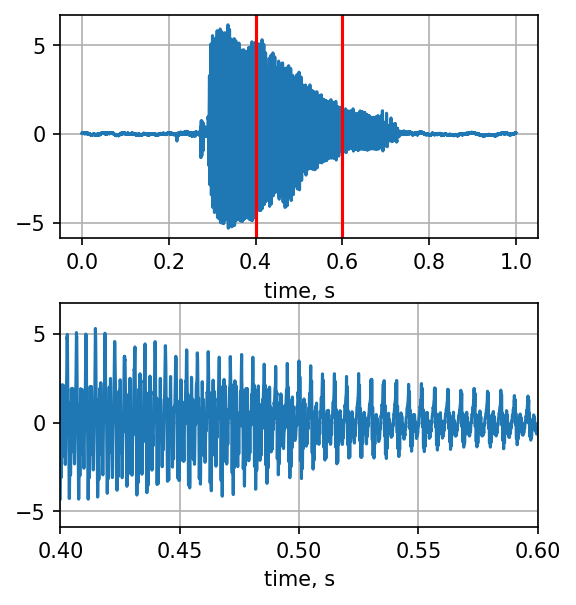

In [5]:
# plot some sample
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
plt.tight_layout()

x = x_train[y_train==3][0]

time = np.arange(len(x))/fs

segment = [0.4, 0.6]
ax[0].plot(time, x)
ax[0].set_xlabel('time, s')
[ax[0].axvline(b, color='r') for b in segment]
ax[1].plot(time, x)
ax[1].set_xlim(segment)
ax[1].set_xlabel('time, s')
sd.play(x, fs)

(129,) (1687, 129)


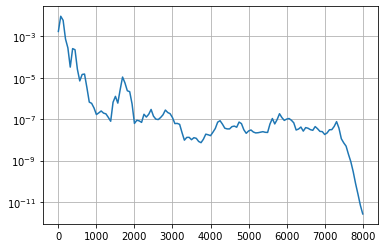

In [6]:
# plot a spectrum of some sample
freq, x_spec_train = sg.welch(x_train, fs, axis=1, )
print(freq.shape, x_spec_train.shape)
plt.semilogy(freq, x_spec_train[y_train==3][1])

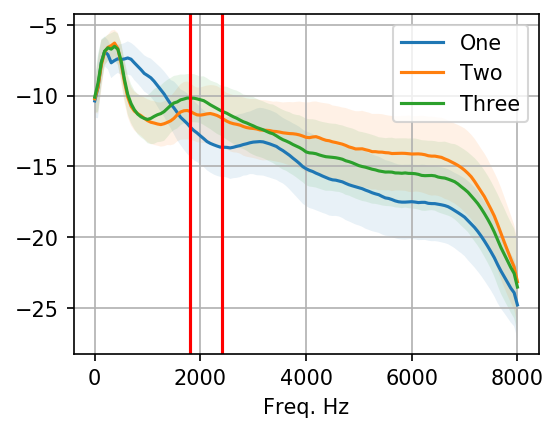

In [7]:
# average spectums for each class
fig, ax = plt.subplots(1, figsize=(4,3), dpi=150)
for k in range(1, 3+1):
    specs = np.log(x_spec_train[y_train==k])
    plt.plot(freq, specs.mean(0), label=['One', 'Two', 'Three'][k-1])
    plt.fill_between(freq, specs.mean(0)-specs.std(0), specs.mean(0)+specs.std(0), alpha=0.1)
    
plt.legend()
plt.xlabel('Freq. Hz')
band = (1800, 2400)
[plt.axvline(b, color='r') for b in band]

In [8]:
# define features transformer
def extract_features(x, band):
    freq, spec = sg.welch(x, fs, axis=1)
    features = spec[:, (freq>band[0]) & (freq<band[1])].mean(1).reshape(-1, 1)
    return features

In [9]:
# extract features
f_train = extract_features(x_train, band)
f_test  = extract_features(x_test, band)
f_global_test = extract_features(x_global_test, band)

In [10]:
# fit model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

classifier = DecisionTreeClassifier()
classifier.fit(f_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
# collect predictions
y_train_pred = classifier.predict(f_train)
y_test_pred = classifier.predict(f_test)
y_global_test_pred = classifier.predict(f_global_test)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.6573799644339063, 0.4564831261101243)

In [12]:
# play a few predictions
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for k in np.random.choice(np.arange(len(x_test)), 5):
    sd.play(x_test[k], fs)
    print('{:12s} {:12s} {}'.format(str(int(y_test_pred[k])), str(int(y_test[k])), y_test_pred[k]==y_test[k]))
    sleep(1.2)

prediction   actual       error       
3            3            True
1            1            True
1            1            True
2            3            False
3            3            True


In [13]:
# save test data predictions
np.savetxt('y_test.txt', y_global_test_pred.astype(int), encoding='utf-8', fmt='%i')

In [14]:
# check submission file
with open('y_test.txt') as f:
    b = f.read()
res = np.array(list(map(int, b.split('\n')[:-1])))
res

array([1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 2, 3, 1, 2, 2, 1, 3, 2, 1, 1, 1,
       1, 3, 1, 1, 1, 2, 2, 2, 3, 1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 2,
       2, 1, 3, 1, 2, 1, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       3, 3, 3, 3, 1, 2, 2, 1, 2, 1, 1, 2, 3, 2, 1, 1, 2, 2, 1, 1, 3, 2,
       1, 3, 1, 1, 2, 3, 1, 3, 2, 1, 2, 2, 2, 1, 1, 1, 3, 3, 1, 2, 2, 2,
       1, 2, 3, 1, 1, 1, 1, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 2, 3,
       3, 2, 2, 1, 2, 2, 1, 1, 2, 3, 3, 1, 1, 2, 3, 2, 2, 1, 3, 1, 3, 2,
       2, 3, 2, 2, 1, 3, 1, 1, 2, 1, 1, 1, 3, 1, 2, 3, 3, 1, 2, 1, 2, 2,
       1, 1, 2, 3, 2, 1, 3, 2, 2, 3, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1,
       1, 2, 1, 1, 2, 3, 2, 1, 1, 2, 1, 1, 1, 3, 2, 3, 3, 2, 3, 1, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 3, 2, 1, 3, 1, 2, 2, 2, 1, 1, 3, 3, 3, 3, 2,
       1, 3, 2, 2, 2, 1, 2, 1, 3, 2, 3, 3, 1, 2, 2, 1, 2, 1, 3, 2, 3, 1,
       2, 2, 1, 3, 1, 2, 3, 2, 3, 2, 1, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 3, 3, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2,